In [12]:
(1/(1e-4+1e-5j)).real

9900.990099009901

In [13]:
def power2(a):
    return 1 << a

def countBits(a):
    ret = 0
    while a != 0:
        ret += a & 0x1
        a = a >> 1
    return ret

def FockStatesNoSpinSymmetryWithRange(n, nrange):
    result = []
    for x in range(power2(n)):
        cx = countBits(x)
        if not cx in nrange:
            continue    
        for x2 in range(power2(n)):
            if countBits(x2) == n - cx:
                result.append((x2 << n) | x)
    result.sort()
    return result

def FockStatesNoSpinSymmetry(n : int):
    """
        only preserving: num in orbitals = num bath.
    """
    result = []
    for x in range(power2(n)):
        cx = countBits(x)  
        for x2 in range(power2(n)):
            if countBits(x2) == n - cx:
                result.append((x2 << n) | x)
    result.sort()
    return result
  

def FockStatesWithSpinSymmetry(n : int):
    """
        preserving: num in orbitals = num bath and total spin is 0
    """
    result = []

    bound = power2(n)
    odds = (bound-1)*4//3 + 1
    odds = odds & (bound-1)
    evens = ~odds & (bound-1)

    for x in range(bound):
        cx = countBits(x)  
        cxOdds = countBits(x & odds) 
        cxEvens = countBits(x & evens)
        for x2 in range(bound):
            if countBits(x2) == n - cx and countBits(x2 & evens) + cxEvens == countBits(x2 & odds) + cxOdds:
                result.append((x2 << n) | x)
    result.sort()
    return result

In [14]:
FockStatesNoSpinSymmetry(4).__len__(), FockStatesWithSpinSymmetry(4).__len__()

(70, 36)

In [15]:
import scipy as sp
import numpy as np

B = np.array(
    [[0.19465008, 0.   ,      0.23183232, 0.,        ],
 [0.,         0.19465008, 0.,         0.23183232],
 [0.19465008, 0.,         0.23183232, 0.        ],
 [0.,         0.19465008, 0.        , 0.23183232]]
)
A = np.array(
    [[0.23183232, 0.   ,      0.23183232, 0.,        ],
 [0.,         0.23183232, 0.,         0.23183232],
 [0.23183232, 0.,         0.23183232, 0.        ],
 [0.,         0.23183232, 0.        , 0.23183232]]
)
sp.linalg.solve(a=A, b=B)


LinAlgError: Matrix is singular.

In [ ]:
np.linalg.eigh(A)

EighResult(eigenvalues=array([0.        , 0.        , 0.46366464, 0.46366464]), eigenvectors=array([[-0.70710678, -0.        ,  0.        , -0.70710678],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ],
       [ 0.70710678,  0.        ,  0.        , -0.70710678],
       [-0.        , -0.70710678,  0.70710678,  0.        ]]))

1. Is this first $\hat{T}$ and then $\hat{T}+\hat{U}$ method general? Would it bias the solutions? maybe cause some solution unavailable.
2. How to improve the numerical accuracy?
3. How to incoperate randomness for nonconvex stochastical optimization? What is the batch?
4. More regulariation on the parameters? Using the continuity in k space? 
5. More parameter for $c$? Which means more basis? Is there systematic way to do overparameterization?
6. Is it useful after achieving the goals above? How does it useful? Read some theory of Gatzwiller paper.

In [ ]:
gz.get_density().reshape(4,4).diag()

In [ ]:
R = gz.get_R()
t_ = torch.einsum("kasbp,ascd,efbp->kcdef", gz.t, R, R) # nkpoints/nei, norb, 2, norb, 2

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2.6))

plt.plot([0.5, 1.0, 1.5, 2.0, 3.0, 3.5, 3.8, 4.0], torch.tensor([0.969, 0.92, 0.862, 0.793, 0.59, 0.435, 0.292, 0.001])**2)
plt.plot([1.0, 2.5, 3.0, 3.2], torch.tensor([0.925, 0.715, 0.59, 0.48])**2, c="tab:green")
plt.plot([2.5, 3.0, 3.2], torch.tensor([0.14, 0.25, 0.48])**2, c="tab:green")

plt.ylabel("Z")
plt.xlabel("U")
plt.ylim(0, 1)
plt.xlim(0, 4.5)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.linalg as LA

mat = torch.randn(5,5)
mat = mat + mat.T

dt = 0.001

A = LA.matrix_exp(-dt * mat)

A_ = torch.eye(5) - dt * mat

vec = torch.randn(5)

In [ ]:
A @ vec - A_ @ vec

In [ ]:
from gGA.operator import Hubbard, Slater_Kanamori
from gGA.nn.ansatz import gGASingleOrb
import numpy as np
import torch

In [ ]:


N = 1
B = 1
model_s = Slater_Kanamori(
    nsites=N*(B+1),
    U=2.0,
    Up=2.0,
    J=0.5,
    Jp=0.5,
    t=np.eye(4),
    n_noninteracting=N*B
)

In [ ]:
sorb = gGASingleOrb(
    norb=2,
    naux=3,
    Hint_params={"U": 2.0, "Up": 2.0, "J": 0.5, "Jp": 0.5, "t": torch.eye(4)},
    device="cpu"
)
R, RDM = sorb.solve_Hemb("ED")

In [ ]:
sorb.LAM_C

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(RDM, cmap="bwr", vmin=-1, vmax=1)
plt.show()

plt.matshow(sorb.LAM_C, cmap="bwr", vmin=-1, vmax=1)
plt.show()

plt.matshow(R, cmap="bwr", vmin=-1, vmax=1)
plt.show()

In [ ]:
model_s.get_quspin_op(2, [(1,1)]).expt_value(np.random.randn(4))

In [ ]:
from gGA.data import OrbitalMapper

In [ ]:
idp = OrbitalMapper(basis={"Si":"4s2p2d1f"}, spin_deg=True)

In [ ]:
idp.full_basis

In [ ]:
idp_aux = OrbitalMapper(basis={"Si":[1, 1, 1, 1, 3, 3, 15, 15, 7]}, spin_deg=False)

In [ ]:
idp_aux.basis, idp.basis, idp.listnorbs, idp_aux.listnorbs

In [ ]:
import torch

a = torch.eye(5).unsqueeze(0).repeat(10,1,1)
x = torch.tensor([0,1,2])
y = torch.tensor([2,3,4])
z = torch.tensor([2,3,4])

In [ ]:
a[x[:,None,None],y[:,None],z[None,:]] = 1

In [ ]:
from gGA.nn.ansatz import gGAtomic
import torch

ga = gGAtomic(
        basis={"C":[1,2]}, 
        atomic_number=torch.tensor([6,6]), 
        idx_intorb={"C":[1]}, 
        intparams={"C":[{"U":2.,"Up":2.,"J":2., "Jp":2.}]}, 
        naux=3, 
        device="cpu",
        spin_deg=False
    )

# ga.update(t={"Si":torch.ones(2,6,6)}, LAM=ga.LAM)

In [ ]:
from gGA.nn.kinetics import Kinetic
import torch

kin = Kinetic(
    nocc=6,
    basis={"C":[1,2]},
    idx_intorb={"C":[0,1]},
    spin_deg=True,
    device=torch.device("cpu"),
    delta_deg=1e-4,
    overlap=False,
)

In [ ]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData

block = {
    "0_0_0_0_0": torch.eye(3,3),
    "1_1_0_0_0": torch.eye(3,3),
    "0_1_0_0_0": torch.randn(3,3),
    "0_1_-1_0_0": torch.randn(3,3)
}

atomicdata = AtomicData.from_ase(
    read("/root/Hubbard/gGA/test/C_chain.vasp"),
    r_max=1.9
    )

atomicdata["kpoint"] = torch.tensor([[0.,0,0]])
block_to_feature(atomicdata, kin.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)

In [ ]:
D, RDM = kin.update(atomicdata, ga.R, ga.LAM)
RDM2 = kin.compute_RDM(atomicdata, ga.R, ga.LAM)

Find E_fermi: 0.0002
DM_kin:  tensor([1.2804e-04, 1.2804e-04, 2.7035e-02, 2.7035e-02, 5.0131e-01, 5.0131e-01,
        5.0703e-01, 5.0703e-01, 9.6625e-01, 9.6625e-01, 9.9825e-01, 9.9825e-01])
DM_emb:  tensor([3.0716e-05, 3.0716e-05, 7.4827e-04, 7.4827e-04, 6.8478e-02, 6.8478e-02,
        2.7942e-01, 2.7942e-01, 9.9828e-01, 9.9828e-01, 9.9972e-01, 9.9972e-01])
	 ## Err of current loop 1: 0.4954, lam_emb: 0.4023, N_emb: 4.69
Find E_fermi: 0.3798
DM_kin:  tensor([0.0010, 0.0010, 0.0100, 0.0100, 0.2251, 0.2251, 0.7642, 0.7642, 0.9998,
        0.9998, 0.9999, 0.9999])
DM_emb:  tensor([1.9148e-04, 1.9148e-04, 3.2951e-03, 3.2951e-03, 6.6976e-02, 6.6976e-02,
        4.0032e-01, 4.0032e-01, 9.9750e-01, 9.9750e-01, 9.9947e-01, 9.9947e-01])
	 ## Err of current loop 2: 0.1334, lam_emb: 1.0258, N_emb: 4.94
Find E_fermi: 0.6391
DM_kin:  tensor([6.9916e-04, 6.9916e-04, 1.0689e-02, 1.0689e-02, 1.7004e-01, 1.7004e-01,
        8.1960e-01, 8.1960e-01, 9.9933e-01, 9.9933e-01, 9.9965e-01, 9.9965e-01])
DM_em

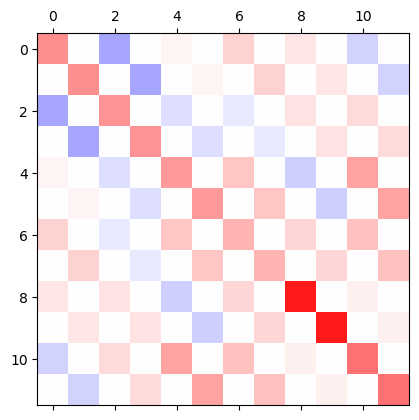

In [2]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData
from gGA.utils.make_kpoints import kmesh_sampling

import torch
from gGA.nn.ghostG import GhostGutzwiller

torch.set_default_dtype(torch.float64)
U = 1.5
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=torch.tensor([6]),
    nocc={"C":[2]},
    basis={"C":[2]},
    idx_intorb={"C":[0]},
    naux=3,
    intparams={"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=1, 
    device=torch.device("cpu"),
    kBT=0.002,
)

block = {
    "0_0_0_0_0": 0.2*torch.diag(torch.tensor([1.,-1.])),
    "0_0_0_0_1": -torch.eye(2)*(1/6),
    "0_0_0_1_0": -torch.eye(2)*(1/6),
    "0_0_1_0_0": -torch.eye(2)*(1/6)
}


# hop = torch.diag(torch.tensor([0.8,1.2,-1.2,-0.8]))
# block = {
#     "0_0_0_0_0": 0.2*torch.diag(torch.tensor([0.8,1.2,-1.2,-0.8])),
#     "0_0_0_0_1": -hop*(1/6),
#     "0_0_0_1_0": -hop*(1/6),
#     "0_0_1_0_0": -hop*(1/6)
# }


atomicdata = AtomicData.from_ase(
    read("/nessa/users/zhanghao/dev/Hubbard/gGA/test/C_cube.vasp"),
    r_max=3.1
    )

atomicdata["kpoint"] = torch.tensor(kmesh_sampling([10,10,10], True)).to(torch.get_default_dtype())
block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)

import matplotlib.pyplot as plt

errs = []
for i in range(150):
    # print(gga.gGAtomic.LAM_C["C"][1].abs().max())
    # err, RDM, RDM_fit, LAMS = gga.update(atomicdata)
    err, RDM = gga.update(atomicdata)
    print("\t ## Err of current loop {:d}: {:.4f}, lam_emb: {:.4f}, N_emb: {:.2f}".format(i+1, err, gga.gGAtomic.LAM_C["C"][0].abs().max().item(), RDM["C"][0].trace()))# , RDM_fit["C"][0].trace()))
    # print(torch.linalg.eigvalsh(RDM["C"][0]))
    errs.append(err)

    # print(gga.gGAtomic.LAM_C)
    # print(RDM["C"][0])
    # print(err)
    # print(torch.linalg.eigvalsh(RDM["C"][0]), RDM["C"][0].trace())

plt.matshow(RDM["C"][0].detach(), cmap="bwr", vmax=1.0, vmin=-1.0)
plt.show()
    # DM_kin:  tensor([0.1600, 0.1600, 0.8400, 0.8400])

In [3]:
torch.linalg.eigvalsh(gga.gGAtomic.LAM["C"][0])

tensor([1.2547, 1.2547, 1.4687, 1.4687, 2.0067, 2.0067, 2.4933, 2.4933, 3.0313,
        3.0313, 3.2453, 3.2453])

In [ ]:
from mpmath import *
mp.dps = 32
one = mpf(1)
mp.pretty = True

def f(x):
    return sqrt(one-x)

a = taylor(f, 0, 20)
pade(a, 10, 10)

([1.0,
  -5.2499999999999999999999999848508,
  11.812499999999999999999999926736,
  -14.874999999999999999999999850481,
  11.484374999999999999999999832682,
  -5.5986328124999999999999998883683,
  1.7106933593749999999999999548058,
  -0.3142089843749999999999999891984,
  0.031723022460937499999999998592662,
  -0.0014686584472656249999999999159514,
  0.000020027160644531249999999998510628],
 [1.0,
  -4.7499999999999999999999999848508,
  9.5624999999999999999999999343102,
  -10.624999999999999999999999881432,
  7.1093749999999999999999998847014,
  -2.9326171874999999999999999347104,
  0.73315429687499999999999997829695,
  -0.10473632812499999999999999594887,
  0.0075531005859374999999999996211251,
  -0.00020980834960937499999999998634195,
  0.00000095367431640624999999999991870571])

In [ ]:
torch.linalg.eigvalsh(gga.gGAtomic.RDM["C"][0])[-3].item()

0.9999999988670557

In [ ]:
gga.gGAtomic.interact_ansatz[0].singleOrbs[0].hermit_basis

tensor([[[0.7071, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071]],

        [[0.0000, 0.0000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000],
         [0.5000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000]]])

In [ ]:
from gGA.nn.ansatz import gGASingleOrb
import torch

gs = gGASingleOrb(
            norb=1,
            naux=1,
            nocc=1,
            intparam={
                "U": 0.,
                "J": 0.,
                "Jp": 0,
                "Up": 3,
            },
            nspin=1,
        )

gs.solve_Hemb(t=torch.eye(1))

(tensor([[ 1.7554e-24,  0.0000e+00],
         [ 0.0000e+00, -4.1414e-40]]),
 array([[2.220446e-16, 0.000000e+00],
        [0.000000e+00, 2.220446e-16]], dtype=float32))

In [ ]:
gga.gGAtomic.interact_ansatz[0].singleOrbs[0].D

tensor([[3.3919e-32, 0.0000e+00, 3.3095e-18, 0.0000e+00],
        [0.0000e+00, 3.3919e-32, 0.0000e+00, 3.3095e-18],
        [1.7948e-31, 0.0000e+00, 1.7512e-17, 0.0000e+00],
        [0.0000e+00, 1.7948e-31, 0.0000e+00, 1.7512e-17]])

In [ ]:
gga.gGAtomic.R

{'C': tensor([[[1.0000, 0.0000, 1.0000, 0.0000],
          [0.0000, 1.0000, 0.0000, 1.0000],
          [1.0000, 0.0000, 1.0000, 0.0000],
          [0.0000, 1.0000, 0.0000, 1.0000]]])}

In [ ]:

    
from gGA.utils.safe_svd import safeSVD
from gGA.utils.diffsrt import MPA_Lya, MPA_Lya_Inv
import torch

def symsqrt(matrix): # this may returns nan grade when the eigenvalue of the matrix is very degenerated.
    """Compute the square root of a positive definite matrix."""
    _, s, v = safeSVD(matrix)
    # _, s, v = torch.svd(matrix)
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)

FastMatSqrt = MPA_Lya.apply
FastInvSqrt = MPA_Lya_Inv.apply


In [ ]:
a = torch.tensor([[ 1.8340e-01,  6.8317e-16, -4.6288e-20,  1.4529e-20],
        [ 6.8317e-16,  1.8340e-01, -7.2841e-20, -7.0720e-20],
        [-4.6288e-20, -7.2841e-20,  1.8338e-01,  2.6299e-16],
        [ 1.4529e-20, -7.0720e-20,  2.6299e-16,  1.8338e-01]]).unsqueeze(0)


In [ ]:
with torch.enable_grad():
    a.requires_grad_()
    out = FastMatSqrt(a)
    grad1 = torch.autograd.grad(out.sum(), a)
    # grad2 = torch.autograd.grad(symsqrt(a).sum(), a)

print(grad1)
# print(grad2)

(tensor([[[1.1675, 1.1675, 1.1676, 1.1676],
         [1.1675, 1.1675, 1.1676, 1.1676],
         [1.1676, 1.1676, 1.1676, 1.1676],
         [1.1676, 1.1676, 1.1676, 1.1676]]]),)


In [ ]:
torch.autograd.gradcheck(func=FastMatSqrt, inputs=(a.unsqueeze(0)))
# torch.autograd.gradcheck(func=symsqrt, inputs=(a))

GradcheckError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 1.1944e+00, -1.1235e-15,  7.2746e-20, -2.7574e-20, -1.1235e-15,
          2.1181e-02, -2.6662e-20,  6.3364e-21,  7.8617e-20, -4.6230e-20,
          2.1165e-02, -4.7181e-17, -2.4639e-20, -1.4912e-21, -7.9242e-17,
          2.1165e-02],
        [ 0.0000e+00,  1.1675e+00,  1.4090e-19,  1.1350e-19,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.3930e-20,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.1310e-20,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.1676e+00, -4.1860e-16,  0.0000e+00,
          0.0000e+00, -1.0873e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -4.1862e-16,  1.1676e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -1.0873e-15,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1675e+00,
          0.0000e+00,  9.3930e-20, -4.6965e-20,  1.1937e-19,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.1056e-19,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.1181e-02, -1.1235e-15, -5.5290e-21, -1.5833e-20, -1.2197e-15,
          1.1944e+00,  1.2989e-19,  1.4723e-19, -1.1400e-20,  1.1815e-19,
          2.1165e-02, -4.7181e-17, -1.0941e-20,  1.5506e-19, -7.9242e-17,
          2.1165e-02],
        [ 0.0000e+00,  0.0000e+00, -1.0873e-15,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.1676e+00, -4.1861e-16,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0873e-15,  0.0000e+00,
          0.0000e+00, -4.1858e-16,  1.1676e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1676e+00, -1.0873e-15,
          0.0000e+00,  0.0000e+00, -4.1860e-16,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0873e-15,  1.1676e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.1860e-16,  0.0000e+00,
          0.0000e+00],
        [ 2.1149e-02, -9.7591e-17,  7.2750e-20, -1.5834e-20, -9.7591e-17,
          2.1149e-02,  1.2989e-19,  6.3425e-21,  6.8836e-20,  1.1424e-19,
          1.2124e+00, -3.6782e-16, -1.0942e-20, -1.4850e-21, -5.2813e-16,
          2.1133e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.8491e-20,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.3930e-20, -2.9353e-20,  1.0176e-19,
          0.0000e+00,  1.1676e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.1860e-16,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.1676e+00, -1.0873e-15,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.1859e-16,
          0.0000e+00,  0.0000e+00, -1.0873e-15,  1.1676e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -3.1310e-20,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0959e-19,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  7.2404e-20,  1.0959e-19,  1.1676e+00,
          0.0000e+00],
        [ 2.1149e-02, -9.7591e-17, -5.5250e-21, -2.7576e-20, -9.7591e-17,
          2.1149e-02, -2.6655e-20,  1.6289e-19, -1.1396e-20, -4.6224e-20,
          2.1133e-02, -5.6019e-16, -2.3662e-20,  1.5898e-19, -4.4797e-16,
          1.2124e+00]], dtype=torch.float64)
analytical:tensor([[ 1.1675e+00, -1.0873e-15,  7.3672e-20, -2.3124e-20, -1.0873e-15,
          2.0251e-30, -1.3722e-34,  4.3070e-35,  7.3672e-20, -1.3722e-34,
          9.2977e-39, -2.9184e-39, -2.3124e-20,  4.3070e-35, -2.9184e-39,
          9.1603e-40],
        [-1.0873e-15,  1.1675e+00,  1.1593e-19,  1.1256e-19,  2.0251e-30,
         -1.0873e-15, -2.1593e-34, -2.0964e-34, -1.3722e-34,  7.3672e-20,
          1.4631e-38,  1.4205e-38,  4.3070e-35, -2.3124e-20, -4.5925e-39,
         -4.4588e-39],
        [ 7.3672e-20,  1.1593e-19,  1.1676e+00, -4.1860e-16, -1.3722e-34,
         -2.1593e-34, -1.0873e-15,  7.7967e-31,  9.2977e-39,  1.4631e-38,
          7.3676e-20, -5.2830e-35, -2.9184e-39, -4.5925e-39, -2.3126e-20,
          1.6582e-35],
        [-2.3124e-20,  1.1256e-19, -4.1860e-16,  1.1676e+00,  4.3070e-35,
         -2.0964e-34,  7.7967e-31, -1.0873e-15, -2.9184e-39,  1.4205e-38,
         -5.2830e-35,  7.3676e-20,  9.1603e-40, -4.4588e-39,  1.6582e-35,
         -2.3126e-20],
        [-1.0873e-15,  2.0251e-30, -1.3722e-34,  4.3070e-35,  1.1675e+00,
         -1.0873e-15,  7.3672e-20, -2.3124e-20,  1.1593e-19, -2.1593e-34,
          1.4631e-38, -4.5925e-39,  1.1256e-19, -2.0964e-34,  1.4205e-38,
         -4.4588e-39],
        [ 2.0251e-30, -1.0873e-15, -2.1593e-34, -2.0964e-34, -1.0873e-15,
          1.1675e+00,  1.1593e-19,  1.1256e-19, -2.1593e-34,  1.1593e-19,
          2.3025e-38,  2.2354e-38, -2.0964e-34,  1.1256e-19,  2.2354e-38,
          2.1703e-38],
        [-1.3722e-34, -2.1593e-34, -1.0873e-15,  7.7967e-31,  7.3672e-20,
          1.1593e-19,  1.1676e+00, -4.1860e-16,  1.4631e-38,  2.3025e-38,
          1.1594e-19, -8.3135e-35,  1.4205e-38,  2.2354e-38,  1.1256e-19,
         -8.0714e-35],
        [ 4.3070e-35, -2.0964e-34,  7.7967e-31, -1.0873e-15, -2.3124e-20,
          1.1256e-19, -4.1860e-16,  1.1676e+00, -4.5925e-39,  2.2354e-38,
         -8.3135e-35,  1.1594e-19, -4.4588e-39,  2.1703e-38, -8.0714e-35,
          1.1256e-19],
        [ 7.3672e-20, -1.3722e-34,  9.2977e-39, -2.9184e-39,  1.1593e-19,
         -2.1593e-34,  1.4631e-38, -4.5925e-39,  1.1676e+00, -1.0873e-15,
          7.3676e-20, -2.3126e-20, -4.1860e-16,  7.7967e-31, -5.2830e-35,
          1.6582e-35],
        [-1.3722e-34,  7.3672e-20,  1.4631e-38,  1.4205e-38, -2.1593e-34,
          1.1593e-19,  2.3025e-38,  2.2354e-38, -1.0873e-15,  1.1676e+00,
          1.1594e-19,  1.1256e-19,  7.7967e-31, -4.1860e-16, -8.3135e-35,
         -8.0714e-35],
        [ 9.2977e-39,  1.4631e-38,  7.3676e-20, -5.2830e-35,  1.4631e-38,
          2.3025e-38,  1.1594e-19, -8.3135e-35,  7.3676e-20,  1.1594e-19,
          1.1676e+00, -4.1862e-16, -5.2830e-35, -8.3135e-35, -4.1862e-16,
          3.0018e-31],
        [-2.9184e-39,  1.4205e-38, -5.2830e-35,  7.3676e-20, -4.5925e-39,
          2.2354e-38, -8.3135e-35,  1.1594e-19, -2.3126e-20,  1.1256e-19,
         -4.1862e-16,  1.1676e+00,  1.6582e-35, -8.0714e-35,  3.0018e-31,
         -4.1862e-16],
        [-2.3124e-20,  4.3070e-35, -2.9184e-39,  9.1603e-40,  1.1256e-19,
         -2.0964e-34,  1.4205e-38, -4.4588e-39, -4.1860e-16,  7.7967e-31,
         -5.2830e-35,  1.6582e-35,  1.1676e+00, -1.0873e-15,  7.3676e-20,
         -2.3126e-20],
        [ 4.3070e-35, -2.3124e-20, -4.5925e-39, -4.4588e-39, -2.0964e-34,
          1.1256e-19,  2.2354e-38,  2.1703e-38,  7.7967e-31, -4.1860e-16,
         -8.3135e-35, -8.0714e-35, -1.0873e-15,  1.1676e+00,  1.1594e-19,
          1.1256e-19],
        [-2.9184e-39, -4.5925e-39, -2.3126e-20,  1.6582e-35,  1.4205e-38,
          2.2354e-38,  1.1256e-19, -8.0714e-35, -5.2830e-35, -8.3135e-35,
         -4.1862e-16,  3.0018e-31,  7.3676e-20,  1.1594e-19,  1.1676e+00,
         -4.1862e-16],
        [ 9.1603e-40, -4.4588e-39,  1.6582e-35, -2.3126e-20, -4.4588e-39,
          2.1703e-38, -8.0714e-35,  1.1256e-19,  1.6582e-35, -8.0714e-35,
          3.0018e-31, -4.1862e-16, -2.3126e-20,  1.1256e-19, -4.1862e-16,
          1.1676e+00]], dtype=torch.float64)


In [ ]:
from gGA.utils.tools import real_hermitian_basis_nspin

basis = real_hermitian_basis_nspin(n=6, nspin=1)

In [ ]:
basis

tensor([[[0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.

In [25]:
import torch
from numpy.linalg import eigh
torch.set_default_dtype(torch.float64)
import numpy as np
from gGA.utils.diffsrt import FastMatSqrt
from gGA.utils.safe_svd import safeSVD

def symsqrt(matrix): # this may returns nan grade when the eigenvalue of the matrix is very degenerated.
    """Compute the square root of a positive definite matrix."""
    # _, s, v = safeSVD(matrix)
    _, s, v = torch.svd(matrix)
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)

def LAM_C_fn(rdm, D, R, hermit_basis):
    RDM = (hermit_basis * rdm[:,None,None]).sum(dim=0)
    out = RDM @ (torch.eye(RDM.shape[0])-RDM)
    # out -= min(torch.linalg.eigvalsh(out).min().item(), -1e-8) * torch.eye(out.shape[0])
    out = FastMatSqrt(out) * (R @ D.T)
    out += out.conj()

    return out.sum()

lag_update_fn = torch.func.grad(LAM_C_fn, argnums=0)

def calc_Lambda_c_ad(R, Lambda, Delta_p, D, H_list):
    l = (Lambda[None,:,:] * H_list).sum(dim=(1,2))
    rdm = (Delta_p[None,:,:] * H_list).sum(dim=(1,2))
    lc = - lag_update_fn(rdm, D, R, H_list) - l
    Lambda_c = (lc[:, None, None] * H_list).sum(0)
    return Lambda_c

def dF(A, H, function, d_function):
    evals, evecs = eigh(A)
    Hbar = np.dot(np.conj(evecs).T, np.dot( H, evecs) ) # transform H to A's basis
    #create Loewner matrix in A's basis
    loewm = np.zeros(evecs.shape,dtype=complex)
    for i in range(loewm.shape[0]):
        for j in range(loewm.shape[1]):
            if i==j:
                loewm[i,i] = d_function(evals[i]) # derivative(function, evals[i], dx=1e-12)
            if i!=j:
                if evals[i] != evals[j]:
                    loewm[i,j]= ( function(evals[i]) - function(evals[j]) )/(evals[i]-evals[j])
                else:
                    loewm[i,j] = d_function(evals[i]) # derivative(function, evals[i], dx=1e-12)

    # Perform the Schur product in A's basis then transform back to original basis.
    deriv = np.dot(evecs, np.dot( loewm*Hbar, np.conj(evecs).T ) )
    return deriv

def dF_improve(A, Hs):
    eigval, eigvec = torch.linalg.eigh(A)
    n = eigval.shape[0]
    Hbar = eigvec.H @ Hs @ eigvec
    fc_eigval = eigval * (1 - eigval)
    fc_eigval = torch.sqrt(fc_eigval)
    dfc_eigval = (0.5 - eigval) / fc_eigval
    loewm = fc_eigval[:,None] - fc_eigval[None,:]
    eigdev = eigval[:, None] - eigval[None, :]
    deg_mask = eigdev.abs().lt(1e-15)
    
    idx = torch.arange(n)[:,None].repeat(1,n)
    r_idx = idx.T[deg_mask]
    l_idx = idx[deg_mask]
    loewm[l_idx, r_idx] = dfc_eigval[r_idx]
    r_idx = idx.T[~deg_mask]
    l_idx = idx[~deg_mask]
    loewm[l_idx, r_idx] /= eigdev[~deg_mask]
    
    deriv = eigvec @ (loewm[None,:,:] * Hbar) @ eigvec.H

    return deriv



def denRm1(x):
    # return (x*((1.0+0.j)-x))**(0.5)
    return (x*((1.0+0.j)-x))**(0.5)

def ddenRm1(x):
    # return ((0.5-x)/(x*((1.0+0.j)-x))**0.5)
    return ((0.5-x)/(x*((1.0+0.j)-x))**0.5)

def calc_Lambda_c(R, Lambda, Delta_p, D, H_list):
    r"""Compute Lambda_c matrix from R, D, Lambda and Delta. It is given by

    .. math::
        \Lambda_c = \sum_s l^c_s h_s

    where :math:`h_s` are a set of matrices that forms a basis for the space of Hermitian matrices
    with dimension :math:`\nu`. The elements :math:`l^c_s` are obtained by calculating

    .. math::
        l^c_s = -l_s - \sum_{\alpha} \text{Tr} \left[ \frac{\partial}{\partial d^P_s} \left[ \Delta ( 1 - \Delta ) ]^{1/2} ( D R^T ) \right]

    where :math:`l_s` are the elements of the decomposition of :math:`\Lambda = \sum_s l_s h_s`
    and :math:`d^P_s` of :math:`\Delta_p = \sum_s d_s h_s^T`.

    Here, extracting the :math:`l_s`s from :math:`\Lambda` is done using the inverse_realHcombination function.
    The derivative with respect to :math:`d^P_s` is done using the dF function.
    :math:`\Lambda_c` is reconstructed using the realHcombinaison function.

    """
    l = inverse_realHcombination(Lambda, H_list)
    lc = np.copy(l) * 0.0
    DR = np.dot(D, np.transpose(R))
    for k in range(len(H_list)):
        AA = Delta_p
        HH = H_list[k].T
        derivative = dF(AA, HH, denRm1, ddenRm1)
        tt = np.trace(np.dot(DR ,derivative))
        lc[k] = -l[k] - (tt + np.conjugate(tt)).real
    Lambda_c = realHcombination(lc, H_list)
    return Lambda_c

def calc_Lambda_c_improve(R, Lambda, Delta_p, D, H_list):
    l = (Lambda[None,:,:] * H_list).sum(dim=(1,2))
    DR = D @ R.T
    driv = dF_improve(Delta_p, H_list.transpose(1,2))
    lc = -(DR[None, :,:] * driv).sum(dim=(1,2))
    lc += lc.conj()
    lc -= l

    Lambda_c = (lc[:, None, None] * H_list).sum(0)

    return Lambda_c


def inverse_realHcombination(H,H_list):
    #H_list,tH_list=Hermitian_list(N)
    M=len(H_list)
    assert(H.shape[0]==H.shape[1])
    #assert(M==N**2)
    #
    x_list=[]
    for i in range(M):
        x_list.append(np.trace(np.dot(H_list[i],H)).real)
    x=np.array(x_list)
    #
    return x

def realHcombination(x,H_list):

    M=len(x)
    N=H_list[0].shape[0]
    assert(H_list[0].shape[0]==H_list[0].shape[1])
    assert(len(x)==len(H_list))
    #
    H=np.zeros((N,N))
    for i in range(M):
        H = H + x[i] * H_list[i]
    #
    return H

In [33]:
from gGA.utils.tools import real_hermitian_basis_nspin


basis = real_hermitian_basis_nspin(4, 4)

R = torch.kron(torch.randn(2,2), torch.eye(2))
D = torch.kron(torch.randn(2,2), torch.eye(2))
Delta_p = torch.kron(torch.tensor([[0.799999999999,-0.4],[-0.4,0.200000000001]]), torch.eye(2))
Lambda = torch.diag(torch.tensor([0.2,0.2,0.8,0.8]))


grad_ana = calc_Lambda_c(
    R=R.numpy(), 
    Lambda=Lambda.numpy(),
    Delta_p=Delta_p.numpy(),
    D=D.numpy(),
    H_list=basis.numpy()
    )

grad_ad = calc_Lambda_c_improve(
    R=R, 
    Lambda=Lambda,
    Delta_p=Delta_p,
    D=D,
    H_list=basis
    )

print(grad_ana - grad_ad.numpy())

print(grad_ana, "\n", grad_ad.numpy())


[[-3.49245965e-10 -1.78308479e-11  3.49245965e-10 -4.73572292e-11]
 [-1.78308479e-11 -6.98491931e-10 -4.64694949e-11  3.49245965e-10]
 [ 3.49245965e-10 -4.64694949e-11  1.74622983e-10 -1.00076392e-10]
 [-4.73572292e-11  3.49245965e-10 -1.00076392e-10 -2.91038305e-10]]
[[ 8.46193358e+05 -1.88438780e+00 -7.22778497e+05 -3.76877560e+00]
 [-1.88438780e+00  8.46006914e+05 -3.76877560e+00 -7.22704586e+05]
 [-7.22778497e+05 -3.76877560e+00 -2.37974988e+05 -7.53755121e+00]
 [-3.76877560e+00 -7.22704586e+05 -7.53755121e+00 -2.38050565e+05]] 
 [[ 8.46193358e+05 -1.88438780e+00 -7.22778497e+05 -3.76877560e+00]
 [-1.88438780e+00  8.46006914e+05 -3.76877560e+00 -7.22704586e+05]
 [-7.22778497e+05 -3.76877560e+00 -2.37974988e+05 -7.53755121e+00]
 [-3.76877560e+00 -7.22704586e+05 -7.53755121e+00 -2.38050565e+05]]


In [29]:
torch.linalg.eigvalsh(torch.tensor([[0.799999999,-0.4],[-0.4,0.200000001]]))

tensor([6.0000e-10, 1.0000e+00])